# 0. Imports

In [61]:
#%matplotlib qt5
%matplotlib inline
#para hacer el grafico animado
#%matplotlib notebook

import matplotlib as mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import bokeh.plotting as bkplt
import bokeh.models as bkmdls
import bokeh.io as bkio

#from windrose import plot_windrose
import matplotlib.cm as cm
#from windrose import WindroseAxes

import mpl_scatter_density

from sklearn import cluster,datasets
from mpl_toolkits.mplot3d import Axes3D


from itertools import cycle
from cycler import cycler
import time
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch
from sklearn import mixture

import matplotlib.colors as colors
import seaborn as sns; sns.set()

import time

# 1. Pre-procesamiento de datos

In [62]:
rutaxls = 'C:/Users/mungu/Documents/DatosWTG.xlsx'
rutaxlsCPot = 'Curva de potencia vestas 90.xlsx'

dataVPxls = pd.read_excel(rutaxls,usecols=[0,1,2],index_col=0,names=['PCTimeStamp','vViento','Pacw'])
dfCPot = pd.read_excel(rutaxlsCPot,usecols=[0,2],index_col=0,names=['PCTimeStamp','pw'])

#marcando los datos faltantes asignando un nan a la fila completa
datamk = dataVPxls
datamk.loc[datamk.isnull().any(axis=1), :] = np.nan

#eliminando filas con NaN. Si busco la fecha anterior debe aparecer error.
cleanData = datamk.dropna()

###calculando la potencia
#la pontencia del archivo de excel es la densidad de potencia acumulada.
#Se tiene que hacer la resta de la potencia siguiente a la anterio y multiplicar por pi*r^2
#el radio es 45m
#si se hace la resta con un array de numpy (values) si se puede restar 
#pues se hace elemento por elemento
dataVP = cleanData.drop('Pacw',axis=1)
dataVP['Pw']= (cleanData.iloc[1:,1].values-cleanData.iloc[0:-1,1]) * np.pi*45**2

#eliminar el ultimo valor pues es NaN
dataVP.drop(dataVP.tail(1).index,inplace=True) 

#Eliminando outliers
dataVP.drop([pd.to_datetime('2016-03-07 09:50:00')],inplace=True)

#leyendo la direccion del viento
dataDirVxls = pd.read_excel(rutaxls,sheet_name=1, usecols=[0,1],index_col=0,names=['PCTimeStamp','Dir'])
#limpiando datos
#marcando los datos faltantes asignando un nan a la fila completa
datamkdir = dataDirVxls
datamkdir.loc[datamkdir.isnull().any(axis=1), :] = np.nan
#eliminando filas con NaN. Si busco la fecha anterior debe aparecer error.
#tambien elimino el ultimo valor como lo hice en los datos de v y p
#el copy es para que no me de la copy warning
dataDir = datamkdir.dropna().copy()
dataDir.drop(dataDir.tail(1).index,inplace=True) 
#eliminando del outlier de viento misma fecha que el de la pontencia
dataDir.drop([pd.to_datetime('2016-03-07 09:50:00')],inplace=True)

direcvrad= np.deg2rad(dataDir['Dir'].values)
velocidades = dataVP.iloc[:]['vViento'].values
vecVel = [-np.sin(direcvrad)*velocidades,np.cos(direcvrad)*velocidades]
vecVelnp=np.array(vecVel).transpose()
#original sin timestamp
#dfVecVel = pd.DataFrame(data=vecVelnp,columns=['vx','vy']
#con timestamp
dfVecVel = pd.DataFrame(data=vecVelnp,columns=['vx','vy'],index=dataVP.index)

In [63]:
#LA CELDA ANTERIOR NO CORRE, ESTA ESTA COPIADA DE OTRO QUE SI FUNCIONA
rutaxls = 'C:/Users/mungu/Documents/DatosWTG.xlsx'
rutaxlsCPot = 'Curva de potencia vestas 90.xlsx'

#dataVPxls = pd.read_excel(rutaxls,usecols=[0,1,2],index_col=0,names=['vViento','Pacw'])
dataVPxls = pd.read_excel(rutaxls,usecols=[0,1,2],index_col=0)
dataVPxls.columns =['vViento','Pacw']
#agrego la columna de potencia instantanea sin filtrar
#dataVPxls['Pw']= (dataVPxls.iloc[1:,1].values-dataVPxls.iloc[0:-1,1]) * np.pi*45**2
print(len(dataVPxls))
#dfCPot = pd.read_excel(rutaxlsCPot,usecols=[0,2],index_col=0,names=['pw'])#cambio esto en la nueva version
dfCPot = pd.read_excel(rutaxlsCPot,usecols=[0,2],index_col=0)
dfCPot.columns = ['pw']
#marcando los datos faltantes asignando un nan a la fila completa
datamk = dataVPxls
datamk.loc[datamk.isnull().any(axis=1), :] = np.nan
#numero de filas sin datos
print('Numero de filas sin datos')
print(datamk.loc[datamk.isnull().any(axis=1), :].isnull().sum())

#eliminando filas con NaN. Si busco la fecha anterior debe aparecer error.
cleanData = datamk.dropna()

###calculando la potencia
#la pontencia del archivo de excel es la densidad de potencia acumulada.
#Se tiene que hacer la resta de la potencia siguiente a la anterio y multiplicar por pi*r^2
#el radio es 45m
#si se hace la resta con un array de numpy (values) si se puede restar 
#pues se hace elemento por elemento
dataVP = cleanData.drop('Pacw',axis=1)
dataVP['Pw']= (cleanData.iloc[1:,1].values-cleanData.iloc[0:-1,1]) * np.pi*45**2

#eliminar el ultimo valor pues es NaN
dataVP.drop(dataVP.tail(1).index,inplace=True) 

#Eliminando outliers
dataVP.drop([pd.to_datetime('2016-03-07 09:50:00')],inplace=True)
#agregado para el reporte
dataVP.drop([pd.to_datetime('2016-03-08 09:00:00')],inplace=True)
dataVP.drop([pd.to_datetime('2016-01-02 06:40:00')],inplace=True)
dataVP.drop([pd.to_datetime('2016-05-05 07:20:00')],inplace=True)
dataVP.drop([pd.to_datetime('2016-05-23 23:00:00')],inplace=True)


#leyendo la direccion del viento
#dataDirVxls = pd.read_excel(rutaxls,sheet_name=1, usecols=[0,1],index_col=0,names=['Dir'])
dataDirVxls = pd.read_excel(rutaxls,sheet_name=1, usecols=[0,1],index_col=0)
dataDirVxls.columns =['Dir']
#limpiando datos
#marcando los datos faltantes asignando un nan a la fila completa
datamkdir = dataDirVxls
datamkdir.loc[datamkdir.isnull().any(axis=1), :] = np.nan
#eliminando filas con NaN. Si busco la fecha anterior debe aparecer error.
#tambien elimino el ultimo valor como lo hice en los datos de v y p
#el copy es para que no me de la copy warning
dataDir = datamkdir.dropna().copy()
dataDir.drop(dataDir.tail(1).index,inplace=True) 
#eliminando del outlier de viento misma fecha que el de la pontencia
dataDir.drop([pd.to_datetime('2016-03-07 09:50:00')],inplace=True)
#agregado para el reporte
dataDir.drop([pd.to_datetime('2016-03-08 09:00:00')],inplace=True)
dataDir.drop([pd.to_datetime('2016-01-02 06:40:00')],inplace=True)
dataDir.drop([pd.to_datetime('2016-05-05 07:20:00')],inplace=True)
dataDir.drop([pd.to_datetime('2016-05-23 23:00:00')],inplace=True)

direcvrad= np.deg2rad(dataDir['Dir'].values)
velocidades = dataVP.iloc[:]['vViento'].values
vecVel = [-np.sin(direcvrad)*velocidades,np.cos(direcvrad)*velocidades]
vecVelnp=np.array(vecVel).transpose()
#original sin timestamp
#dfVecVel = pd.DataFrame(data=vecVelnp,columns=['vx','vy']
#con timestamp
dfVecVel = pd.DataFrame(data=vecVelnp,columns=['vx','vy'],index=dataVP.index)

#datos direccion velocidad
print(len(dataVP))
print(len(dataDir))
dataDV = pd.concat([dataDir,dataVP.vViento],axis=1)
dataDVP = pd.concat([dataDir,dataVP.Pw,dataVP.vViento],axis=1)
dataVcD =pd.concat([dataDir,dfVecVel],axis=1)
#Datos en p.u.. Divido todos los datos entre el máximo del conjunto de datos


#OPERATIONAL DATA	
# Rated power
# 2,000 kW/2,200 kW
# Cut-in wind speed	4 m/s
# Cut-out wind speed	25 m/s
# Re cut-in wind speed	23 m/s

cutin_speed = 4
cutoff_speed = 25#segun el datasheet
recutin_speed= 23

52848
Numero de filas sin datos
vViento    312
Pacw       312
dtype: int64
52530
52530


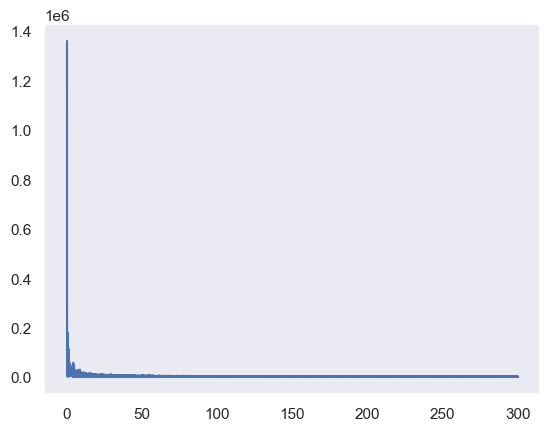

In [64]:
from scipy.fftpack import fft
# Number of sample points
N = dataVP.Pw.shape[0]
# sample spacing
T = 1.0 / (10*60)
x = np.linspace(0.0, N*T, N)
yf = fft(dataVP.Pw.values)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

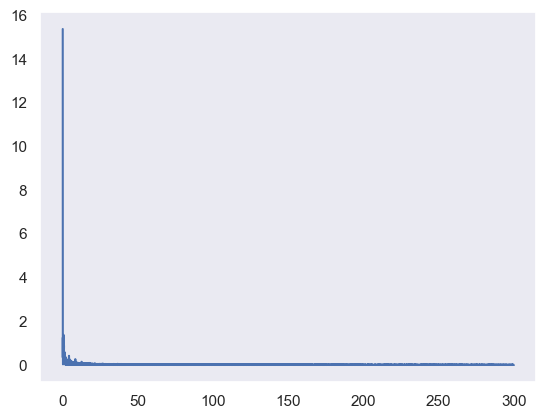

In [65]:
from scipy.fftpack import fft
# Number of sample points
N = dataVP.vViento.shape[0]
# sample spacing
T = 1.0 / (10*60)
x = np.linspace(0.0, N*T, N)
yf = fft(dataVP.vViento.values)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

<AxesSubplot:xlabel='velocidad'>

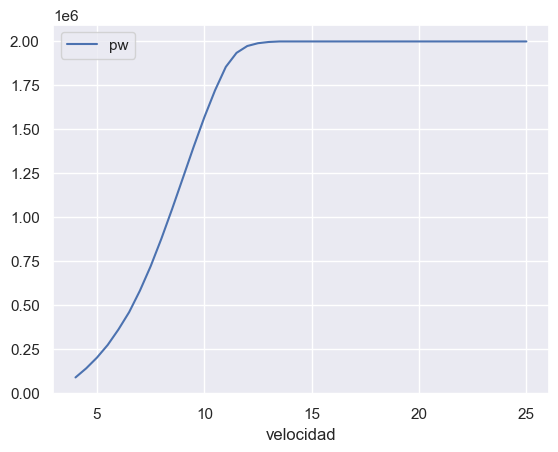

In [66]:
dfCPot.plot()

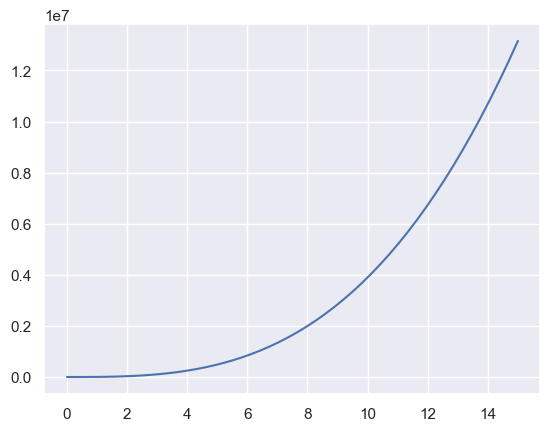

In [67]:
# P = 1/2 ρ A V^3
rho =1.225 
A=np.pi*45**2
V=np.linspace(0,15)
P = 0.5*rho*A*V**3
plt.figure()
plt.plot(V,P)

# 2. Rosa de los vientos y Weibull

In [68]:
#creando un dataframe con los tres valores
dfveldirpot = dataVP.copy()
dfveldirpot['Dir'] = dataDir


In [69]:
'''
#https://windrose.readthedocs.io/en/latest/usage.html
df = pd.DataFrame({'speed': dfveldirpot.vViento, 'direction':dfveldirpot.Dir })
plot_windrose(df, kind='bar', normed=True,  cmap=cm.hot, lw=3)
plot_windrose(df, kind='pdf')
ax = WindroseAxes.from_ax()
ax.bar(dfveldirpot.Dir, dfveldirpot.vViento, normed=True)
table = ax._info['table']
wd_freq = np.sum(table, axis=0)
plt.figure()
direction = ax._info['dir']
wd_freq = np.sum(table, axis=0)
plt.bar(np.arange(16), wd_freq)
xlabels = ('N','','N-E','','E','','S-E','','S','','S-O','','O','','N-O','')
xticks=range(16)
plt.gca().set_xticks(xticks)
plt.draw()
plt.gca().set_xticklabels(xlabels)

plt.draw()
'''

"\n#https://windrose.readthedocs.io/en/latest/usage.html\ndf = pd.DataFrame({'speed': dfveldirpot.vViento, 'direction':dfveldirpot.Dir })\nplot_windrose(df, kind='bar', normed=True,  cmap=cm.hot, lw=3)\nplot_windrose(df, kind='pdf')\nax = WindroseAxes.from_ax()\nax.bar(dfveldirpot.Dir, dfveldirpot.vViento, normed=True)\ntable = ax._info['table']\nwd_freq = np.sum(table, axis=0)\nplt.figure()\ndirection = ax._info['dir']\nwd_freq = np.sum(table, axis=0)\nplt.bar(np.arange(16), wd_freq)\nxlabels = ('N','','N-E','','E','','S-E','','S','','S-O','','O','','N-O','')\nxticks=range(16)\nplt.gca().set_xticks(xticks)\nplt.draw()\nplt.gca().set_xticklabels(xlabels)\n\nplt.draw()\n"

# 3. Clusterizando

### K-means

In [70]:
km_nclusters =5
kmeans = cluster.KMeans(n_clusters=km_nclusters, random_state=0).fit(dfVecVel)
km_clcenters = kmeans.cluster_centers_
km_labels=kmeans.labels_ 

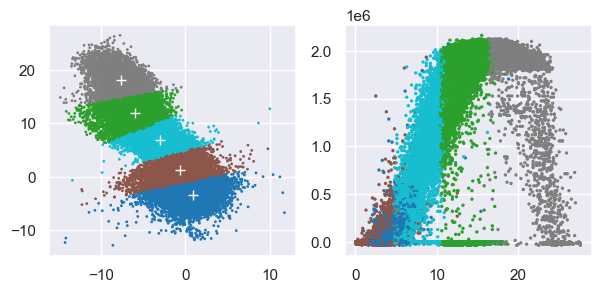

In [71]:
fig = plt.figure(100,figsize=(7,3))

#subplot1
ax = fig.add_subplot(121)
ax.scatter(dfVecVel.vx,dfVecVel.vy,c=km_labels,s=1,cmap='tab10')
for i in range(km_nclusters):
    ax.plot(km_clcenters[i][0],km_clcenters[i][1],'+',markersize=7,mew=1,c='w')
ax = fig.add_subplot(122)
ax.scatter(dataVP['vViento'] ,dataVP['Pw'],s=2,c=km_labels,cmap='tab10')
plt.show();



### Mean shift

In [72]:
# #############################################################################
# Compute clustering with MeanShift

# The following bandwidth can be automatically detected using
bandwidth = cluster.estimate_bandwidth(dfVecVel.values, quantile=0.05, n_samples=500)

ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(dfVecVel.values)
ms_labels = ms.labels_
ms_clcenters = ms.cluster_centers_

labels_unique = np.unique(ms_labels)
ms_nclusters = len(labels_unique)

print("number of estimated clusters : %d" % ms_nclusters)


number of estimated clusters : 16


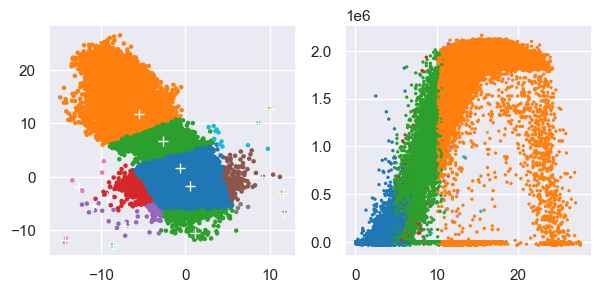

In [73]:
fig = plt.figure(101,figsize=(7,3))

#subplot1
ax = fig.add_subplot(121)
ax.scatter(dfVecVel.vx,dfVecVel.vy,c=ms_labels,cmap='tab10',s=5)
for i in range(ms_nclusters):
    ax.plot(ms_clcenters[i][0],ms_clcenters[i][1],'+',markersize=7,mew=1,c='w')
ax = fig.add_subplot(122)
ax.scatter(dataVP['vViento'] ,dataVP['Pw'],s=2,c=ms_labels,cmap='tab10')
plt.show();


### Affinity propagation

In [74]:

# af = cluster.AffinityPropagation().fit(dfVecVel.values)
# cluster_centers_indices = af.cluster_centers_indices_
# labels = af.labels_

# n_clusters_ = len(cluster_centers_indices)

### Spectral clustering

In [75]:
# from sklearn.feature_extraction import image
# import time

# # Convert the image into a graph with the value of the gradient on the
# # edges.
# graph = image.img_to_graph(dfVecVel.values)

# # Take a decreasing function of the gradient: an exponential
# # The smaller beta is, the more independent the segmentation is of the
# # actual image. For beta=1, the segmentation is close to a voronoi
# beta = 5
# eps = 1e-6
# graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps

# # Apply spectral clustering (this step goes much faster if you have pyamg
# # installed)
# N_REGIONS = 25

In [76]:
# for assign_labels in ('kmeans', 'discretize'):
#     t0 = time.time()
#     labels = cluster.spectral_clustering(graph, n_clusters=N_REGIONS,
#                                  assign_labels=assign_labels, random_state=1)
#     t1 = time.time()
#     labels = labels.reshape(dfVecVel.values.shape)

#     plt.figure(figsize=(5, 5))
#     plt.imshow(dfVecVel.values, cmap=plt.cm.gray)
#     for l in range(N_REGIONS):
#         plt.contour(labels == l, contours=1,
#                     colors=[plt.cm.nipy_spectral(l / float(N_REGIONS))])
#     plt.xticks(())
#     plt.yticks(())
#     title = 'Spectral clustering: %s, %.2fs' % (assign_labels, (t1 - t0))
#     print(title)
#     plt.title(title)
# plt.show()

### Aglomerative clustering

In [77]:
# #sin memoria
# import time
# from sklearn.cluster import spectral_clustering
# from sklearn import manifold, datasets

# # 2D embedding of the digits dataset
# print("Computing embedding")
# X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(dfVecVel.values)
# print("Done.")


# for linkage in ('ward', 'average', 'complete'):
#     clustering = cluster.AgglomerativeClustering(linkage=linkage, n_clusters=10)
#     t0 = time()
#     clustering.fit(X_red)
#     print("%s : %.2fs" % (linkage, time() - t0))

#     plot_clustering(X_red, X, clustering.labels_, "%s linkage" % linkage)


### Minimum Spanning tree

In [78]:

from mst_clustering import MSTClustering
model = MSTClustering(cutoff_scale=1)
mst_labels = model.fit_predict(dfVecVel.values)
mst_nclusters = len(np.unique(model.labels_))
print('Número de clusters: %d'%mst_nclusters)


Número de clusters: 33


In [79]:
# matplotlib 1.4 + numpy 1.10 produces warnings; we'll filter these
import warnings; warnings.filterwarnings('ignore', message='elementwise')

def plot_mst(model, cmap='rainbow'):
    """Utility code to visualize a minimum spanning tree"""
    X = model.X_fit_
    fig, ax = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)
    for axi, full_graph, colors in zip(ax, [True, False], ['lightblue', model.labels_]):
        segments = model.get_graph_segments(full_graph=full_graph)
        axi.plot(segments[0], segments[1], '-k', zorder=1, lw=1)
        axi.scatter(X[:, 0], X[:, 1], c=colors, cmap=cmap, zorder=2,s=3)
        axi.axis('tight')
    
    ax[0].set_title('Full Minimum Spanning Tree', size=16)
    ax[1].set_title('Trimmed Minimum Spanning Tree', size=16);

In [80]:
len(np.unique(model.labels_))

33

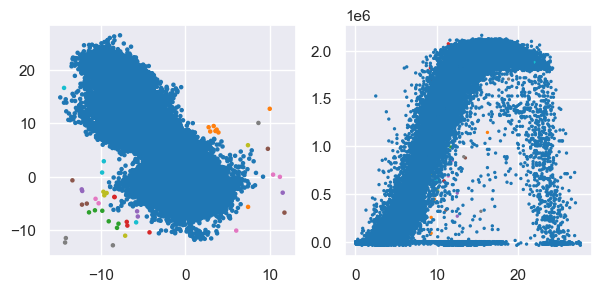

In [81]:
fig = plt.figure(103,figsize=(7,3))

#subplot1
ax = fig.add_subplot(121)
ax.scatter(dfVecVel.vx,dfVecVel.vy,c=mst_labels,cmap='tab10',s=5)
ax = fig.add_subplot(122)
ax.scatter(dataVP['vViento'] ,dataVP['Pw'],s=2,c=mst_labels,cmap='tab10')
plt.show();

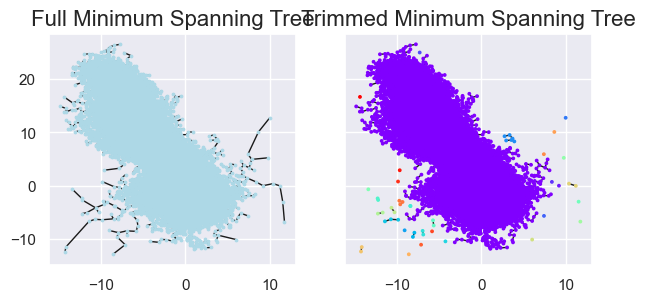

In [82]:
plot_mst(model)


### DBSCAN

Estimated number of clusters: 3
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.916
Silhouette Coefficient: 0.626


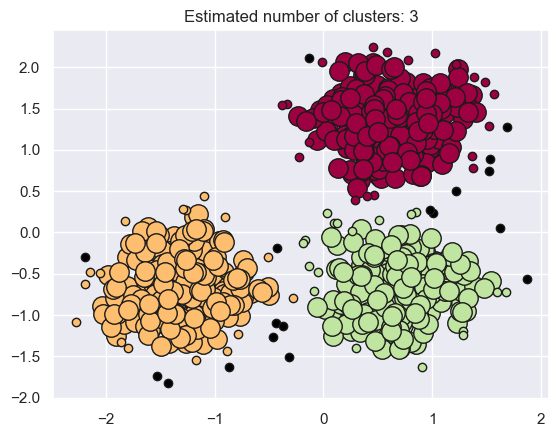

In [109]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [110]:
X = StandardScaler().fit_transform(dfVecVel.values)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(min_samples=2,eps=0.3).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels))
n_clusters_

8

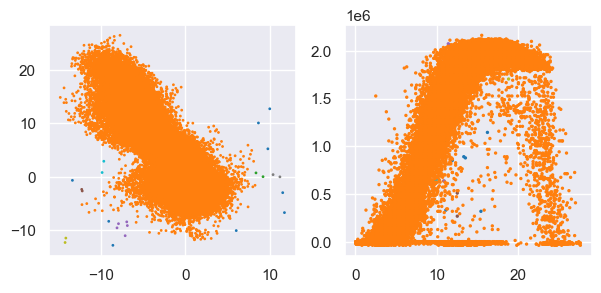

In [111]:

fig = plt.figure(105,figsize=(7,3))

#subplot1
ax = fig.add_subplot(121)
ax.scatter(dfVecVel.vx,dfVecVel.vy,c=labels,s=1,cmap='tab10')
# for i in range(km_nclusters):
#     ax.plot(km_clcenters[i][0],km_clcenters[i][1],'+',markersize=7,mew=1,c='w')
ax = fig.add_subplot(122)
ax.scatter(dataVP['vViento'] ,dataVP['Pw'],s=2,c=labels,cmap='tab10')
plt.show();


### Gaussian Mixture

In [112]:
nc=5
g = mixture.GaussianMixture(n_components=nc, covariance_type='diag')  # number of components
g.fit(dfVecVel)
gm_labels = g.predict(dfVecVel)
gm_means=g.means_

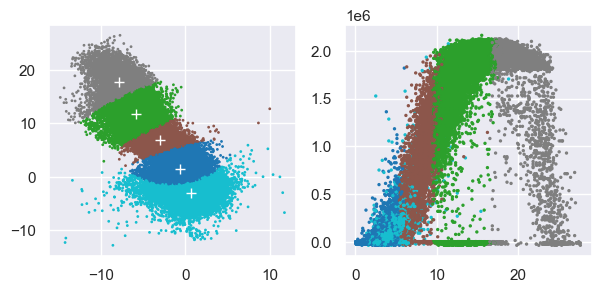

In [113]:


fig = plt.figure(9,figsize=(7,3))

#subplot1
ax = fig.add_subplot(121)
ax.scatter(dfVecVel.vx,dfVecVel.vy,c=gm_labels,s=1,cmap='tab10')
for i in range(km_nclusters):
    ax.plot(gm_means[i][0],gm_means[i][1],'+',markersize=7,mew=1,c='w')
ax = fig.add_subplot(122)
ax.scatter(dataVP['vViento'] ,dataVP['Pw'],s=2,c=gm_labels,cmap='tab10')
plt.show();


### Birch

Birch without global clustering as the final step took 1.51 seconds
n_clusters : 46
Birch with global clustering as the final step took 1.19 seconds
n_clusters : 5


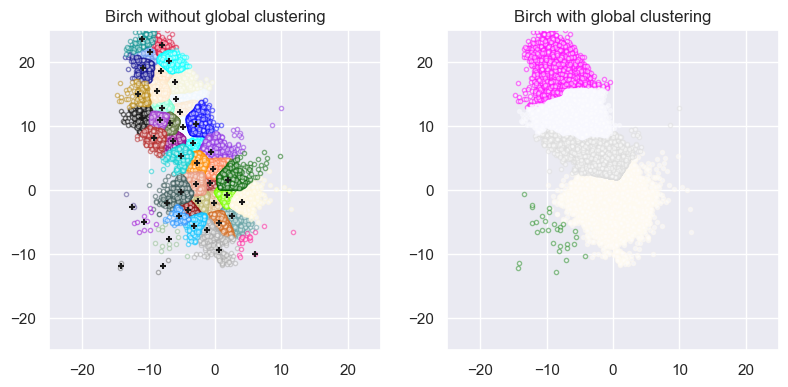

In [114]:
from itertools import cycle
from time import time
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch, MiniBatchKMeans
import matplotlib.colors as colors

X =dfVecVel.values



# Use all colors that matplotlib provides by default.
colors_ = cycle(colors.cnames.keys())

fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.1, top=0.9)

# Compute clustering with Birch with and without the final clustering step
# and plot.
birch_models = [Birch(threshold=1.7, n_clusters=None),
                Birch(threshold=1.7, n_clusters=5)]
final_step = ['without global clustering', 'with global clustering']


for ind, (birch_model, info) in enumerate(zip(birch_models, final_step)):
    t = time()
    birch_model.fit(X)
    time_ = time() - t
    print("Birch %s as the final step took %0.2f seconds" % (
          info, (time() - t)))

    # Plot result
    labels = birch_model.labels_
    centroids = birch_model.subcluster_centers_
    n_clusters = np.unique(labels).size
    print("n_clusters : %d" % n_clusters)

    ax = fig.add_subplot(1, 3, ind + 1)
    for this_centroid, k, col in zip(centroids, range(n_clusters), colors_):
        mask = labels == k
        ax.scatter(X[mask, 0], X[mask, 1],
                   c='w', edgecolor=col, marker='.', alpha=0.5)
        if birch_model.n_clusters is None:
            ax.scatter(this_centroid[0], this_centroid[1], marker='+',
                       c='k', s=25)
    ax.set_ylim([-25, 25])
    ax.set_xlim([-25, 25])
    ax.set_autoscaley_on(False)
    ax.set_title('Birch %s' % info)

# 4. Comparacion Birch, kmeans, gaussian mixture

In [115]:
n_clusters=5

In [116]:
#Birch
# forzar n  clusters
model_birch = Birch(threshold=1.7, n_clusters=n_clusters)
model_birch.fit(dfVecVel.values) 
bch_labels = model_birch.labels_
centroids = model_birch.subcluster_centers_#los centroides siguen siendo 46
n_clusters = np.unique(bch_labels).size

In [117]:
#Kmeans
kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=0).fit(dfVecVel)
km_clcenters = kmeans.cluster_centers_
km_labels=kmeans.labels_ 

In [118]:
#gaussian mixture
g = mixture.GaussianMixture(n_components=n_clusters, covariance_type='diag')  # number of components
g.fit(dfVecVel)
gm_labels = g.predict(dfVecVel)
gm_means=g.means_

In [119]:
#orden de aparicion de los clusters kmeans y gm

#ordenar el orden de aparicion segun la magnitud de la vv
bchmagni = np.zeros(n_clusters)
kmmagni = np.zeros(n_clusters)
gmmagni = np.zeros(n_clusters)
for i in range(n_clusters):
    bchvx = dfVecVel.vx.values[bch_labels==i]
    bchvy = dfVecVel.vy.values[bch_labels==i]
    bchmagni[i]= round(np.mean(np.sqrt(bchvx**2 + bchvy**2)),1) #magnitud de la vv
    kmvx = dfVecVel.vx.values[km_labels==i]
    kmvy = dfVecVel.vy.values[km_labels==i]
    kmmagni[i]= round(np.mean(np.sqrt(kmvx**2 + kmvy**2)),1) #magnitud de la vv
    gmvx = dfVecVel.vx.values[gm_labels==i]
    gmvy = dfVecVel.vy.values[gm_labels==i]
    gmmagni[i]= round(np.mean(np.sqrt(gmvx**2 + gmvy**2)),1) #magnitud de la vv

bchord = bchmagni.argsort()
kmord = kmmagni.argsort()
gmord = gmmagni.argsort()

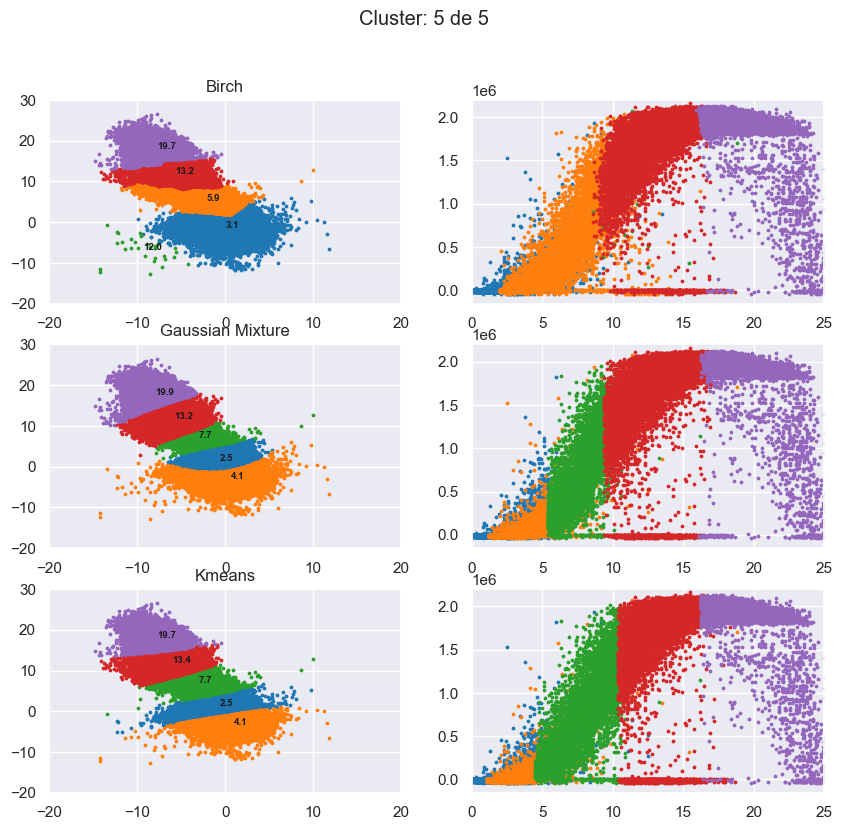

In [120]:

#para hacer plot animado
#https://stackoverflow.com/questions/34486642/what-is-the-currently-correct-way-to-dynamically-update-plots-in-jupyter-ipython
colorcycler = cycler('color', plt.cm.tab20(np.linspace(0.0,1,10)))
plt.ion()
fig = plt.figure(7,figsize=(10,9));
ax1 = fig.add_subplot(321);ax2 = fig.add_subplot(322);
ax3 = fig.add_subplot(323);ax4 = fig.add_subplot(324);
ax5 = fig.add_subplot(325);ax6 = fig.add_subplot(326);

#ciclo de colores al dibujar los clusters
for ax in fig.axes:
    ax.set_prop_cycle(colorcycler);

ax1.set_xlim((-20,20));ax1.set_ylim((-20,30))
ax2.set_xlim((0,25));ax2.set_ylim((-155000,2200000))
ax3.set_xlim((-20,20));ax3.set_ylim((-20,30))
ax4.set_xlim((0,25));ax4.set_ylim((-155000,2200000))
ax5.set_xlim((-20,20));ax5.set_ylim((-20,30))
ax6.set_xlim((0,25));ax6.set_ylim((-155000,2200000))

ax1.set_title('Birch')
ax5.set_title('Kmeans')
ax3.set_title('Gaussian Mixture');
for i in range(n_clusters):
    bchxpw = dataVP.vViento[bch_labels==bchord[i]]
    bchypw = dataVP.Pw[bch_labels==bchord[i]]
    bchvx = dfVecVel.vx.values[bch_labels==bchord[i]]
    bchvy = dfVecVel.vy.values[bch_labels==bchord[i]]
    
    plt.suptitle('Cluster: '+str( i+1)+ ' de ' + str(n_clusters))
    sc1= ax1.scatter(bchvx,bchvy,s=3) 
    #magvv= round(np.mean(np.sqrt(bchvx**2 + bchvy**2)),1) #magnitud de la vv
    ax1.text(bchvx.mean(),bchvy.mean(),bchmagni[bchord[i]],fontsize=7,
             weight = 'bold',color='k')
    ax2.scatter(bchxpw,bchypw,s=3) 
    
    kxpw = dataVP.vViento[km_labels==kmord[i]]
    kypw = dataVP.Pw[km_labels==kmord[i]]
    kvx = dfVecVel.vx.values[km_labels==kmord[i]]
    kvy = dfVecVel.vy.values[km_labels==kmord[i]]
    ax5.scatter(kvx,kvy,s=3) 
    #kmagvv= round(np.mean(np.sqrt(kvx**2 + kvy**2)),1) #magnitud de la vv
    ax5.text(km_clcenters[kmord[i],0],km_clcenters[kmord[i],1],kmmagni[kmord[i]],fontsize=7,
             weight = 'bold',color='k')
    ax6.scatter(kxpw,kypw,s=3) 
    
    gmxpw = dataVP.vViento[gm_labels==gmord[i]]
    gmypw = dataVP.Pw[gm_labels==gmord[i]]
    gmvx = dfVecVel.vx.values[gm_labels==gmord[i]]
    gmvy = dfVecVel.vy.values[gm_labels==gmord[i]]
    ax3.scatter(gmvx,gmvy,s=3) 
    #gmmagvv= round(np.mean(np.sqrt(gmvx**2 + gmvy**2)),1) #magnitud de la vv
    ax3.text(gm_means[gmord[i],0],gm_means[gmord[i],1],gmmagni[gmord[i]],fontsize=7,
             weight = 'bold',color='k')
    ax4.scatter(gmxpw,gmypw,s=3) 
    fig.canvas.draw()

    #time.sleep(1)    



# 5. Comparacion con slider

IntSlider(value=1, max=5, min=1)

Checkbox(value=False, description='Un solo cluster')

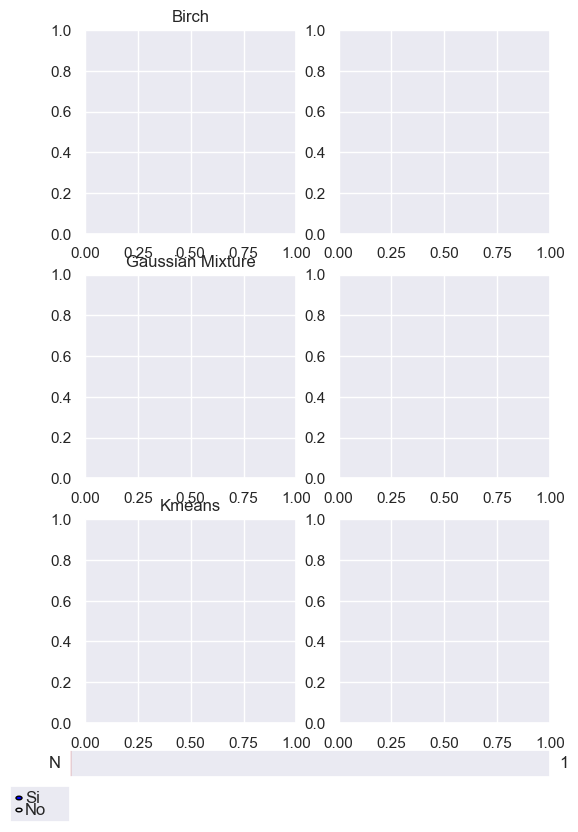

In [121]:


from matplotlib.widgets import RadioButtons, TextBox
from IPython.display import display
import ipywidgets as widgets
import mpl_scatter_density

#slider
w = widgets.IntSlider(max=n_clusters,min=1,step=1)
display(w)
wdgChk= widgets.Checkbox(
    value=False,
    description='Un solo cluster',
    disabled=False
)
display(wdgChk)
#para hacer plot animado
#https://stackoverflow.com/questions/34486642/what-is-the-currently-correct-way-to-dynamically-update-plots-in-jupyter-ipython

#parametros slider
a_min = 1    # the minimial value of the paramater a
a_max = n_clusters   # the maximal value of the paramater a
a_init =1    # the value of the parameter a to be used initially, when the graph is created

plt.ion()
fig = plt.figure(8,figsize=(6,9));

ax1 = fig.add_subplot(321);ax2 = fig.add_subplot(322);
ax3 = fig.add_subplot(323);ax4 = fig.add_subplot(324);
ax5 = fig.add_subplot(325);ax6 = fig.add_subplot(326);


slider_ax = plt.axes([0.1, 0.05, 0.8, 0.03])
a_slider = plt.Slider(slider_ax,      # the axes object containing the slider
                  'N',            # the name of the slider parameter
                  a_min,          # minimal value of the parameter
                  a_max,          # maximal value of the parameter
                  valinit=a_init, # initial value of the parameter
                  valstep=1,      # Entero 
                  valfmt='%d' #el print
                 )
rad = plt.axes([0.0, 0.0, 0.1, 0.04])
#si solo se dibuja un cluster o todos
radiob = RadioButtons(rad, ('Si', 'No'), active=0)

ax1.set_title('Birch')
ax5.set_title('Kmeans')
ax3.set_title('Gaussian Mixture');

# #normalizar numero de clusters de 0 a 1 para pasar el valor de
# #i a color
# norm = matplotlib.colors.Normalize(vmin=0, vmax=n_clusters)
cmp = mpl.cm.get_cmap('tab10')

bchxpw=[];bchypw =[];bchypw=[];bchvx=[];bchvy=[]
kxpw=[];kypw=[];kvx=[];kvy=[]
gmxpw=[];gmypw=[];gmvx=[];gmvy=[]
bchvxmean=[];bchvymean=[]

for i in range(n_clusters):
    bchxpw.append( dataVP.vViento[bch_labels==bchord[i]])
    bchypw.append( dataVP.Pw[bch_labels==bchord[i]])
    bchvx.append( dfVecVel.vx.values[bch_labels==bchord[i]])
    bchvy.append( dfVecVel.vy.values[bch_labels==bchord[i]])
    kxpw.append( dataVP.vViento[km_labels==kmord[i]])
    kypw.append(dataVP.Pw[km_labels==kmord[i]])
    kvx.append( dfVecVel.vx.values[km_labels==kmord[i]])
    kvy.append( dfVecVel.vy.values[km_labels==kmord[i]])
    gmxpw.append(dataVP.vViento[gm_labels==gmord[i]])
    gmypw.append(dataVP.Pw[gm_labels==gmord[i]])
    gmvx.append(dfVecVel.vx.values[gm_labels==gmord[i]])
    gmvy.append(dfVecVel.vy.values[gm_labels==gmord[i]])
    bchvxmean.append(bchvx[i].mean())
    bchvymean.append(bchvy[i].mean())
#fig.canvas.draw()

def updatePlot(val):
    #ncl = val-1 #empieza en cero
    #ncl = int(a_slider.val)-1
    ax1.axes.clear();ax2.axes.clear()
    ax3.axes.clear();ax4.axes.clear()
    ax5.axes.clear();ax6.axes.clear()
    ax1.set_xlim((-20,20));ax1.set_ylim((-20,30))
    ax2.set_xlim((0,25));ax2.set_ylim((-155000,2200000))
    ax3.set_xlim((-20,20));ax3.set_ylim((-20,30))
    ax4.set_xlim((0,25));ax4.set_ylim((-155000,2200000))
    ax5.set_xlim((-20,20));ax5.set_ylim((-20,30))
    ax6.set_xlim((0,25));ax6.set_ylim((-155000,2200000))
    ax1.set_title('Birch')
    ax5.set_title('Kmeans')
    ax3.set_title('Gaussian Mixture');
    
    #if radiob.value_selected =='Si': #pertenece al checkbox de matplotlib
    if wdgChk.value==False:
        #ncl =range(int(a_slider.val)) 
        ncl =range(w.get_interact_value())#solo si uso el slider de matplotlib y no el widget de jupyter
    else:
        ncl=[w.get_interact_value()-1]#solo si uso el slider de matplotlib y no el widget de jupyter
        #ncl=[int(a_slider.val)-1]
    
        
    for i in ncl:
        a_slider.val=i
        plt.suptitle('Cluster: '+str( i+1)+ ' de ' + str(n_clusters))
        ax1.scatter(bchvx[i],bchvy[i],s=3,c=cmp(i),alpha=1) 
        ax1.text(bchvxmean[i],bchvymean[i],bchmagni[bchord[i]],fontsize=7,
                 weight = 'bold',color='k')
        ax2.scatter(bchxpw[i],bchypw[i],s=1,c=cmp(i))
        #texto manitud de velocidad en el grafico de potencia
        ax2.text(dataVP.vViento[bch_labels==bchord[i]].median(),dataVP.Pw[bch_labels==bchord[i]].median(),bchmagni[bchord[i]],fontsize=7,
                     weight = 'bold',color='k')
    
        ax5.scatter(kvx[i],kvy[i],s=1,c=cmp(i)) 
        ax5.text(km_clcenters[kmord[i],0],km_clcenters[kmord[i],1],kmmagni[kmord[i]],fontsize=7,
                 weight = 'bold',color='k')
        ax6.scatter(kxpw[i],kypw[i],s=1,c=cmp(i)) 
        ax6.text(dataVP.vViento[km_labels==kmord[i]].median(),dataVP.Pw[km_labels==kmord[i]].median()
                 ,kmmagni[kmord[i]],fontsize=7, weight = 'bold',color='k')
    
        ax3.scatter(gmvx[i],gmvy[i],s=1,c=cmp(i)) 
        ax3.text(gm_means[gmord[i],0],gm_means[gmord[i],1],gmmagni[gmord[i]],fontsize=7,
                 weight = 'bold',color='k')
        ax4.scatter(gmxpw[i],gmypw[i],s=1,c=cmp(i)) 
        ax4.text(dataVP.vViento[gm_labels==gmord[i]].median(),dataVP.Pw[gm_labels==gmord[i]].median(),
            gmmagni[gmord[i]],fontsize=7,weight = 'bold',color='k')

        #if radiob.value_selected =='Si':
        if wdgChk.value==False:
            fig.canvas.draw()
            time.sleep(1)
        #fig.canvas.draw()
        fig.canvas.flush_events()
        
#solo si uso el slider de matplotlib y no el widget de jupyter
#a_slider.on_changed(updatePlot)
w.observe(updatePlot,'value')
wdgChk.observe(updatePlot,'value')
plt.show()


# 6. Scatter density

C:\Users\mungu\anaconda3\lib\site-packages\mpl_scatter_density\generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
C:\Users\mungu\anaconda3\lib\site-packages\mpl_scatter_density\generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


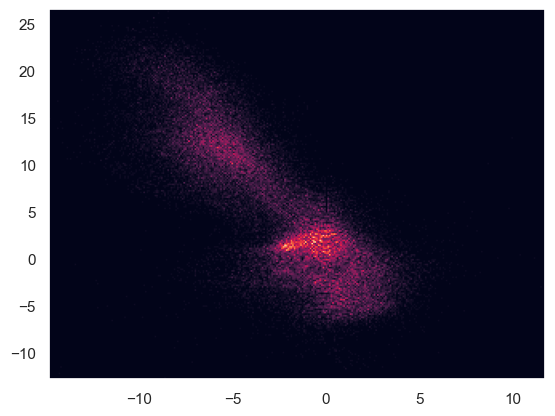

In [122]:
import mpl_scatter_density
fig = plt.figure(11)
ax1 = fig.add_subplot(111,projection='scatter_density')
ax1.scatter_density(dfVecVel.vx,dfVecVel.vy,downres_factor=1)
ax1.grid()

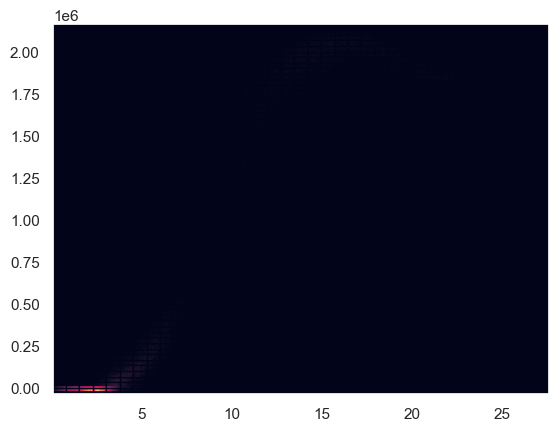

In [123]:
fig = plt.figure(12)
ax1 = fig.add_subplot(111,projection='scatter_density')
ax1.scatter_density(dataVP.vViento,dataVP.Pw)
ax1.grid()

# 7. Stacked bar graph

In [124]:
#nombre de las columnas del dataframe
columnas = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']
dfclpw = pd.DataFrame()
for i in range(n_clusters):
    dfclpw = pd.concat([dfclpw,dataVP.Pw[bch_labels==bchord[i]]], ignore_index=True, axis=1)
dfclpw.columns=columnas[0:n_clusters]

In [125]:
dfclpw.head()

,C1,C2,C3,C4,C5
2016-01-01 00:00:00,NaN,NaN,NaN,1.953050e+06,NaN
2016-01-01 00:10:00,NaN,NaN,NaN,2.067561e+06,NaN
2016-01-01 00:20:00,NaN,NaN,NaN,2.048475e+06,NaN
2016-01-01 00:30:00,NaN,NaN,NaN,2.080284e+06,NaN
2016-01-01 00:40:00,NaN,NaN,NaN,2.073922e+06,NaN


## Histogramas con el cero

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

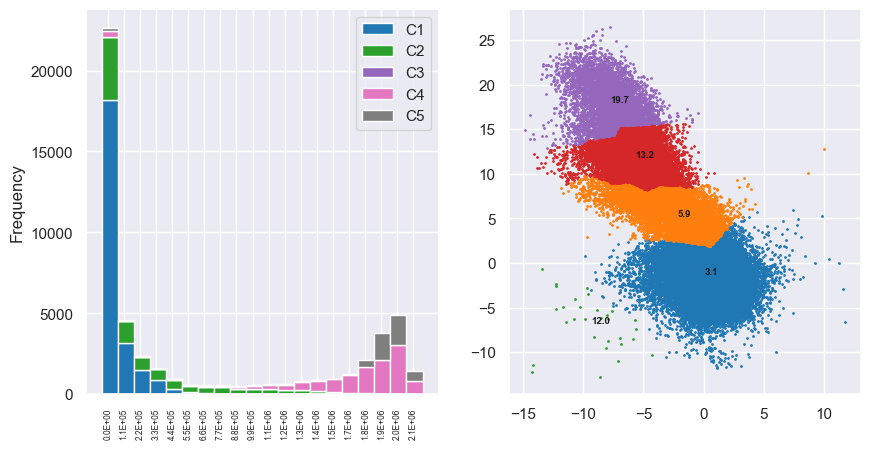

In [126]:
#primero correr el mapa con slider
#custom colormap para hacer un "tab9" eliminando el primer color
cmp = mpl.cm.get_cmap('tab10')
tab9 =  mpl.colors.LinearSegmentedColormap.from_list('tab9', cmp.colors[1:], N=9)
#para empatar con el plot animado de 8 clusters
#hay que cambiar estos colores cuando cambie el numero de cluster, ajustar cmp.colors al
#rango adecuado y N al numero de clusters
tab8 =  mpl.colors.LinearSegmentedColormap.from_list('tab8', cmp.colors[0:-2], N=8)
#tab7 sin el cero
tab7_wo0 =  mpl.colors.LinearSegmentedColormap.from_list('tab7', cmp.colors[1:-2], N=7)



#cmp ordenado a bch_labels
fig = plt.figure(70,figsize=(10,5))
ax = fig.subplots(nrows=1, ncols=2)

for i in range(n_clusters):
        ax[1].scatter(bchvx[i],bchvy[i],s=1,c=cmp(i))
        ax[1].text(bchvxmean[i],bchvymean[i],bchmagni[bchord[i]],fontsize=7,
                 weight = 'bold',color='k')

axdf= dfclpw.plot.hist(stacked=True,cmap=tab8,bins=20,rot=90,ax=ax[0])       
axdf.tick_params(labelsize=6,labelrotation=90,axis='x');
axdf.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.1E"));
axdf.xaxis.set_ticks(np.linspace(0,2100000,20));
    

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

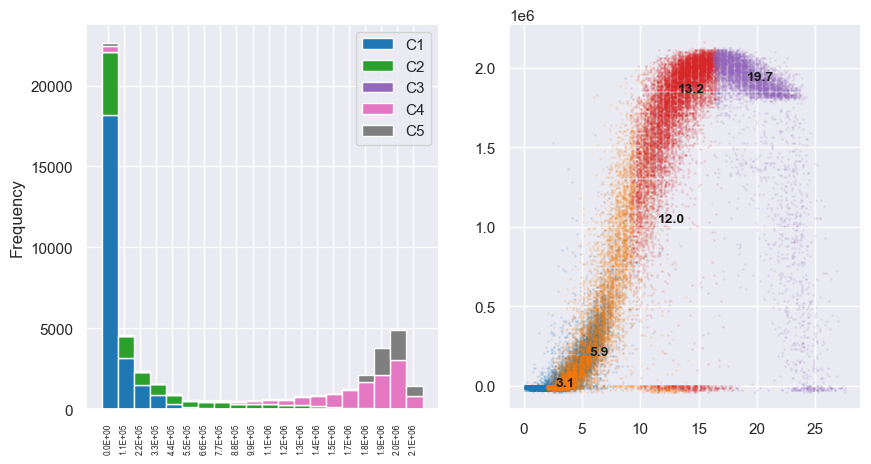

In [127]:
#custom colormap para hacer un "tab9" eliminando el primer color

fig = plt.figure(71,figsize=(10,5))
ax = fig.subplots(nrows=1, ncols=2)

axdf= dfclpw.plot.hist(stacked=True,cmap=tab8 ,bins=20,rot=90,ax=ax[0])       
axdf.tick_params(labelsize=6,labelrotation=90,axis='x')
axdf.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.1E"))
axdf.xaxis.set_ticks(np.linspace(0,2100000,20))

for i in range(n_clusters):
    ax[1].scatter(bchxpw[i],bchypw[i],s=1,c=cmp(i),alpha=0.1)
    ax[1].text(dataVP.vViento[bch_labels==bchord[i]].median(),dataVP.Pw[bch_labels==bchord[i]].median(),bchmagni[bchord[i]],fontsize=10,
                     weight = 'bold',color='k')    


    

## Histogramas sin el cero

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

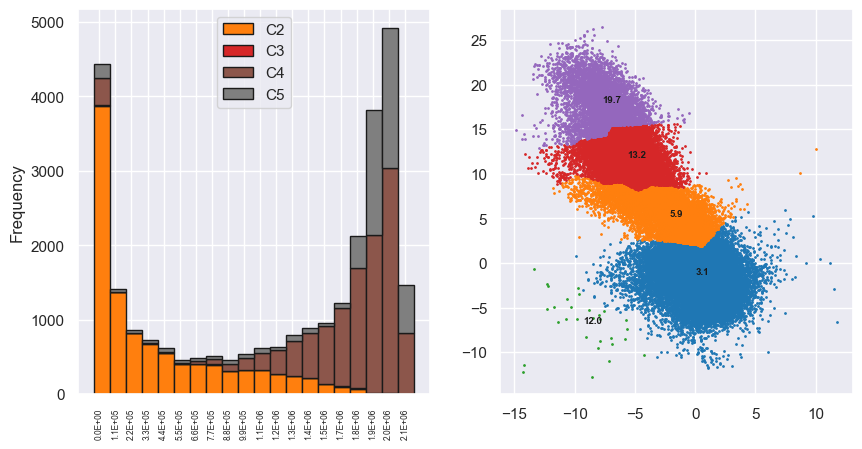

In [128]:
#
fig = plt.figure(72,figsize=(10,5))
ax = fig.subplots(nrows=1, ncols=2)

for i in range(n_clusters):
    ax[1].scatter(bchvx[i],bchvy[i],s=1,c=cmp(i))
    ax[1].text(bchvxmean[i],bchvymean[i],bchmagni[bchord[i]],fontsize=7,
                     weight = 'bold',color='k')

axdf= dfclpw[columnas[1:n_clusters]].plot.hist(stacked=True,cmap=tab7_wo0,bins=20,rot=90,ax=ax[0],edgecolor='k') ;      
axdf.tick_params(labelsize=6,labelrotation=90,axis='x');
axdf.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.1E"));
axdf.xaxis.set_ticks(np.linspace(0,2100000,20));


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

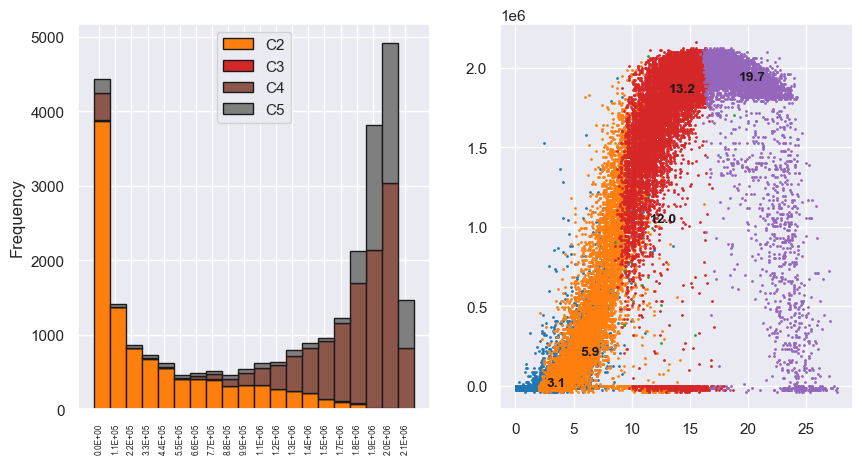

In [129]:
#
fig = plt.figure(73,figsize=(10,5))
ax = fig.subplots(nrows=1, ncols=2)

for i in range(n_clusters):
    ax[1].scatter(bchxpw[i],bchypw[i],s=1,c=cmp(i))
    ax[1].text(dataVP.vViento[bch_labels==bchord[i]].median(),dataVP.Pw[bch_labels==bchord[i]].median(),bchmagni[bchord[i]],fontsize=10,
                     weight = 'bold',color='k')    


axdf= dfclpw[columnas[1:n_clusters]].plot.hist(stacked=True,cmap=tab7_wo0,bins=20,rot=90,ax=ax[0],edgecolor='k') ;      
axdf.tick_params(labelsize=6,labelrotation=90,axis='x');
axdf.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.1E"));
axdf.xaxis.set_ticks(np.linspace(0,2100000,20));


# 8. Dataframe de velocidades por cluster

In [130]:
#nombre de las columnas del dataframe
#https://stackoverflow.com/questions/37835508/how-to-do-multi-column-from-tuples
colheaders = []
for i in range(n_clusters):
    colheaders.append(('C'+str(i+1),'vx'))
    colheaders.append(('C'+str(i+1),'vy'))
    
dfclvv= pd.DataFrame()
for i in range(n_clusters):
    dfclvv = pd.concat([dfclvv,dfVecVel.vx[bch_labels==bchord[i]],dfVecVel.vy[bch_labels==bchord[i]]], 
                       axis=1,ignore_index=True)

#crear multiindice
dfclvv.columns = pd.MultiIndex.from_tuples(colheaders)
#dfclvv
dfclpw

,C1,C2,C3,C4,C5
2016-01-01 00:00:00,NaN,NaN,NaN,1.953050e+06,NaN
2016-01-01 00:10:00,NaN,NaN,NaN,2.067561e+06,NaN
2016-01-01 00:20:00,NaN,NaN,NaN,2.048475e+06,NaN
2016-01-01 00:30:00,NaN,NaN,NaN,2.080284e+06,NaN
2016-01-01 00:40:00,NaN,NaN,NaN,2.073922e+06,NaN
...,...,...,...,...,...
2017-01-01 23:00:00,0.000000,NaN,NaN,NaN,NaN
2017-01-01 23:10:00,-12723.450247,NaN,NaN,NaN,NaN
2017-01-01 23:20:00,-12723.450247,NaN,NaN,NaN,NaN
2017-01-01 23:30:00,0.000000,NaN,NaN,NaN,NaN


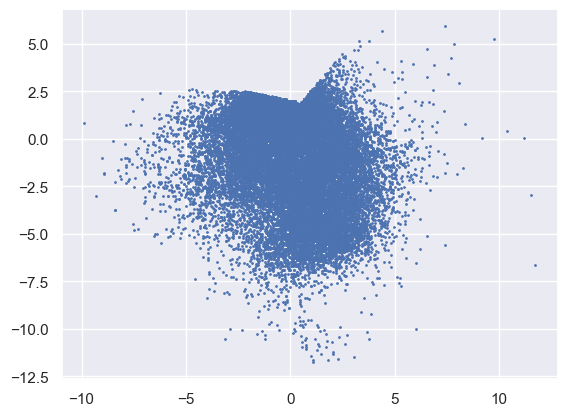

In [131]:

fig82 = plt.figure(82)
plt.scatter(dfclvv.C1.vx,dfclvv.C1.vy,s=1)
plt.show()

# 9. Modelo gaussiano por estado

In [132]:
#definiciones
def gaussian_2d(x, y, x0, y0, xsig, ysig):
    return 1/(2*np.pi*xsig*ysig) * np.exp(-0.5*(((x-x0) / xsig)**2 + ((y-y0) / ysig)**2))

def plotGMM(ax, g, n, pt,limix=[-25,25],limiy=[-25,25]):
    #ax, subplot donde se ploteara
    #limix y limiy son los valores minimos y maximos de los datos (y coordenadas)
    delta = 0.025

    x = np.arange(limix[0], limix[1], delta) 
    y = np.arange(limiy[0], limiy[1], delta) 
    X, Y = np.meshgrid(x, y)

    if pt == 1:
        for i in range(n):
            Z1 = gaussian_2d(X, Y, g.means_[i, 0], g.means_[i, 1], g.covariances_[i, 0], g.covariances_[i, 1])
            ax.contour(X, Y, Z1, 10, linewidths=1,cmap='Paired')
            ax.plot(g.means_[i][0],g.means_[i][1], '+', markersize=13, mew=3)

ValueError: The number of passed axes must be 5, the same as the output plot

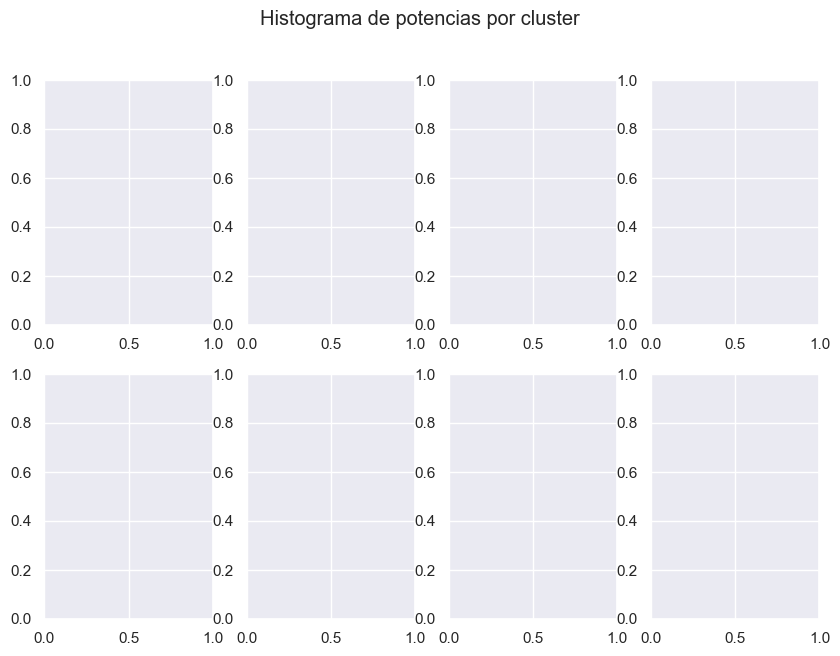

In [133]:
#nombre de las columnas del dataframe
columnas = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']
dfclpw = pd.DataFrame()
for i in range(n_clusters):
    dfclpw = pd.concat([dfclpw,dataVP.Pw[bch_labels==bchord[i]]], ignore_index=True, axis=1)
dfclpw.columns=columnas[0:n_clusters]
fig91 = plt.figure(91, figsize=(10,7))
ax = fig91.subplots(ncols=4,nrows=2);
fig91.suptitle('Histograma de potencias por cluster')
dfclpw.hist(ax = ax, edgecolor='k',bins=50);

In [ ]:
fig92 = plt.figure(92, figsize=(10,9))
ax = fig92.subplots(ncols=4,nrows=4);
fig92.suptitle('Histograma de velocidades por cluster')
dfclvv.hist(ax = ax, edgecolor='k');

In [ ]:
nc = 2 #ncols
nr = 4 #nrows
fig93 = plt.figure(93, figsize=(10,9))
ax = fig93.subplots(ncols=nc,nrows=nr);
fig93.suptitle('Scatter plots de velocidades por cluster')
n = 1

for j in range(nr):
    for i in range(nc):
        ax[j,i].scatter(dfclvv['C'+str(n)].vx,dfclvv['C'+str(n)].vy,s=1,c=tab8(n-1))
        n=n+1

In [ ]:
g = []
gm_labels=[]
gm_means=[]
ngauss=6
for i in range(n_clusters):
    g.append(mixture.GaussianMixture(n_components=ngauss, covariance_type='diag'))  # number of components
    g[i].fit(dfclvv['C'+str(i+1)].dropna())
    gm_labels.append(g[i].predict(dfclvv['C'+str(i+1)].dropna()))
    gm_means.append(g[i].means_)

In [ ]:
fig94 = plt.figure(94, figsize=(10,9))
ax = fig94.subplots(ncols=nc,nrows=nr);
fig94.suptitle('Scatter plots de velocidades por cluster')

n = 1
ngauss=3 # número de gaussianas

for j in range(nr):
    for i in range(nc):
        ax[j,i].scatter(dfclvv['C'+str(n)].vx,dfclvv['C'+str(n)].vy,s=1,c=tab8(n-1))
        plotGMM(ax[j,i],g[n-1], ngauss, 1,
            limix=[dfclvv['C'+str(n)].vx.min().round(),dfclvv['C'+str(n)].vx.max().round()],
            limiy=[dfclvv['C'+str(n)].vy.min().round(),dfclvv['C'+str(n)].vy.max().round()])
        ax[j,i].scatter(dfclvv['C'+str(n)].vx,dfclvv['C'+str(n)].vy,s=1,c=tab8(n))
        n=n+1


In [ ]:


delta = 0.025


fig95 = plt.figure(95, figsize=(10,9))

for n in range(n_clusters):
    x = np.arange(dfclvv['C'+str(n+1)].vx.min().round(), dfclvv['C'+str(n+1)].vx.max().round(), delta) 
    y = np.arange(dfclvv['C'+str(n+1)].vy.min().round(), dfclvv['C'+str(n+1)].vy.max().round(), delta) #como se ve en el histograma (mas o menos)
    X, Y = np.meshgrid(x, y)
    ax = fig95.add_subplot(241+n,projection='3d')
    ax.set_title('C'+str(n))
    for i in range(3):
            Z1 = gaussian_2d(X, Y, g[n].means_[i, 0], g[n].means_[i, 1], g[n].covariances_[i, 0], g[n].covariances_[i, 1])
            #para dejar solo una parte de las guassianas
            #Z1[Z1 < 1*np.exp(-7)] = None
            #Z1[Z1 <= 1*np.exp(10)*Z1.min()] = None
            ax.contour(X, Y, Z1, 30,linewidths=3)
            
            #ax.plot_surface(X,Y,Z1,shade=False,alpha=0.4,rstride=8, cstride=8)
            ax.view_init(40,220)

            #print(Z1.min())
            #X, Y, Z = axes3d.get_test_data(0.05)
            #cset = ax.contour(X, Y, Z, cmap=cm.coolwarm)
#ax.clabel(cset, fontsize=9, inline=1)

#plt.tight_layout()
plt.show()


In [ ]:

delta = 0.025


fig95 = plt.figure(95, figsize=(10,9))

for n in range(n_clusters):
    x = np.arange(dfclvv['C'+str(n+1)].vx.min().round()-3, dfclvv['C'+str(n+1)].vx.max().round()+3, delta) 
    y = np.arange(dfclvv['C'+str(n+1)].vy.min().round()-3, dfclvv['C'+str(n+1)].vy.max().round()+3, delta) #como se ve en el histograma (mas o menos)
    X, Y = np.meshgrid(x, y)
    ax = fig95.add_subplot(241+n,projection='3d')
    ax.set_title('C'+str(n))
    Z1= np.zeros([y.shape[0],x.shape[0]]) 
    
    for i in range(3):
            Z1 = Z1 + gaussian_2d(X, Y, g[n].means_[i, 0], g[n].means_[i, 1], g[n].covariances_[i, 0], g[n].covariances_[i, 1])
            #para dejar solo una parte de las guassianas
            #Z1[Z1 < 1*np.exp(-7)] = None
    #Z1[Z1 <= 1*np.exp(8)*Z1.min()] = None
    ax.contour(X, Y, Z1, 30,linewidths=3)        
   
    
    #ax.plot_surface(X,Y,Z1,shade=False,alpha=0.7,rstride=8, cstride=8)
    #ax.view_init(40,220)
    #print(Z1.min())
            
#ax.clabel(cset, fontsize=9, inline=1)
#plt.tight_layout()
plt.show()


Articulo: Time-series clustering - A decade review
Time point clustering:gory of clustering which is seen in some papers [74–76]. It is clustering of time points based on a combination of their temporal proximity of time points and the similarity of the corre- sponding values.